# 0 Preliminaries
In this section we deal with imports and parameters for the execution of the reste of the code

In [111]:
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
import os
import scipy.optimize as optim
import math

In [2]:
# Path to the folder of images
#database_path = '/home/dimitribouche/Bureau/ENSAE/CompressedSensing/CroppedYale'
database_path = '/Users/Remi/Documents/ENSAE/3A/Compressed Sensing/Reconaissance faciale/CroppedYale'
# Proportion of data to be used for learning (used for testing : 1 - learn_slice)
learn_slice = 0.5

# 1 Data base treatment
## 1.1 Read pgm function
In this subsection, we introduce a function to read the pgm images and store them in a numpy array

In [3]:
def read_pgm(pgmf):
    """
    Create a numpy array from a .pgm image file
    
    Args:
        pgmf (file) : a .pgm file opened in python
    Returns:
        numpy.ndarray. The .pgm file as a 2d numpy array
    """
    # Make sure that 
    #assert pgmf.readline() == 'P5\n'
    pgmf.readline().split()
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    image = []
    for y in range(height):
        row = []
        for y in range(width):
            row.append(ord(pgmf.read(1)))
        image.append(row)
    return np.array(image)


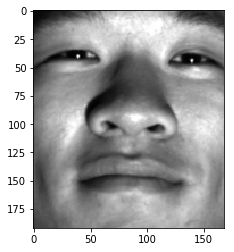

In [4]:
# Test of the read_pgm function on a given image
testfile = open(database_path + '/yaleB13/yaleB13_P00A-010E-20.pgm', 'rb')
testimage = read_pgm(testfile)

# Show the image
plt.imshow(testimage, cmap="gray")
plt.show()

## 1.2 Load full database
In this subsection, we use our pgm reader to loop over the folders and files in the database to load the full database

In [5]:
def load_database(path, flatten=True):
    """
    Load the face database from computer
    
    Args:
        path (str): the folder containing the 'CroppedYale' folder
        flatten (bool): Should images be flattened ?
    
    Returns:
        list. A list of list of numpy array. Index of first list is for the individual, 
        index of the second list is the index of the image of the individual
    """
    database = []
    count = 0
    # Each folder contains the pictures for a given individual
    # We loop over folders
    for foldername in os.listdir(path):
        # Create empty container for the images of the individual
        database.append([])
        # Loop over images
        for filename in os.listdir(path + '/' + foldername):
            # Load only images files
            if filename.endswith(".pgm"):
                # Open file
                im = open(path + '/' + foldername + '/' + filename, 'rb')
                # Convert to numpy array, jump file is conversion is not a success
                try :
                    im_np = read_pgm(im)
                except ValueError :
                    # Skip the file "ambient" which are pictures of the background of the faces, unecessary in our case
                    continue
                # Append the new image to the list of images of the individual
                if flatten:
                    database[count].append(im_np.flatten())
                else:
                    database[count].append(im_np)
        count += 1
    return database

In [6]:
# Load the Yale B extended database using our loader
data = load_database(database_path, flatten=False)

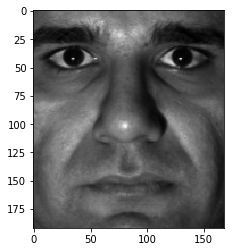

In [7]:
# Test : show a face in the database
# The index states that this is the 9th image for the 7th individual
plt.imshow(data[7][9], cmap="gray")
plt.show()

## 1.3 Division of the data in test/learn sets
In this subsection we introduce the divide_learn_test function that divide the database two : a learn set and a test set

In [175]:
def divide_learn_test(faces_data, learn_slice=0.5):
    """
    Divide the faces database into a learn set and a test set
    
    Args : 
        faces_data (list) : The database in the format of output from load_database function
        learn_slice (float) : How much of the database should be used for learning ? (0.5 : half)
    
    Returns :
        tuple. A tuple of list, the learn set and the test set
    """
    learn_data = []
    test_data = []
    for person in range(0, len(faces_data)):
        n_images = len(faces_data[person])
        shuffle(faces_data[person])
        split_index = int(learn_slice * n_images)
        learn_data.append(faces_data[person][0: split_index])
        test_data.append(faces_data[person][split_index: ])
    return learn_data, test_data

In [176]:
# Divide data base in learn and test using the divide_learn_test function
data_learn, data_test = divide_learn_test(data, learn_slice=learn_slice)

## 1.4 Stack learn data in a matrix
In this section we introduce a function to stack the learn data in a matrix

In [177]:
def stack_images(faces_data):
    dim_stacked = faces_data[0][0].shape[0] * faces_data[0][0].shape[1]
    n_images = sum([len(faces_data[i]) for i in range(0, len(faces_data))])
    images_matrix = np.zeros(shape=(dim_stacked, n_images), dtype=np.int64)
    cum_ind = 0
    for i in range(0, len(faces_data)):
        len(faces_data[i])
        for j in range(0, len(faces_data[i])):
            images_matrix[:, j + cum_ind] = faces_data[i][j].flatten().T
        cum_ind += len(faces_data[i])
    return images_matrix

In [178]:
# Create and fill the matrix of images using the stack_images function defined above
im_mat = stack_images(data_learn)
print(im_mat)
print(im_mat.shape)

[[ 17 157 109 ...  61 110  37]
 [ 19 157 108 ...  62 111  38]
 [ 23 169 115 ...  65 112  39]
 ...
 [ 32   6   5 ...   3   2   4]
 [ 36   6   6 ...   4   2   1]
 [ 46   7   5 ...   4   2   2]]
(32256, 1205)


## 1.5 Stack test data in vectors
In this section we introduce a function to stack the test data in list of vectors

In [153]:
# Create and fill the vectors of test images using the stack_images function defined above
def stack_data_to_vec(data_test):
    test_im_mat = stack_images(data_test)
    nb_cols = test_im_mat.shape[1]
    test_im_vec = []
    for i in range(0,nb_cols):
        test_im_vec.append(np.array(test_im_mat[:,i]))
    nb_test_im = len(test_im_vec)
    N = len(test_im_mat[:,0])
    return test_im_vec, nb_test_im, N

In [181]:
test_im_vec, nb_test_im, N = stack_data_to_vec(data_test)
print(nb_test_im)
print(N)
print(test_im_vec)
print(test_im)

1219
32256
[array([122, 115, 117, ...,   4,   5,   5], dtype=int64), array([177, 197, 171, ...,   3,   5,   5], dtype=int64), array([ 99, 100,  98, ...,   3,   4,   6], dtype=int64), array([  6,   7,   8, ...,  76,  95, 117], dtype=int64), array([71, 83, 90, ...,  4,  5,  7], dtype=int64), array([  5,   5,   5, ..., 107, 113, 116], dtype=int64), array([246, 229, 231, ...,   5,   8,   8], dtype=int64), array([119, 119, 130, ...,   8,   8,   8], dtype=int64), array([175, 166, 170, ...,   5,   6,   7], dtype=int64), array([ 5,  5,  3, ..., 57, 64, 75], dtype=int64), array([53, 55, 60, ..., 23, 26, 32], dtype=int64), array([ 4,  4,  4, ..., 71, 79, 84], dtype=int64), array([  4,   4,   4, ...,  92, 111, 107], dtype=int64), array([123, 124, 127, ...,   4,   6,   6], dtype=int64), array([90, 90, 93, ..., 17, 14, 13], dtype=int64), array([1, 0, 0, ..., 0, 0, 1], dtype=int64), array([16, 18, 22, ...,  7,  6,  5], dtype=int64), array([ 6,  7,  8, ..., 20, 34, 49], dtype=int64), array([73, 73, 8

[array([94, 94, 96, ...,  6,  7,  8], dtype=int64), array([74, 76, 81, ..., 26, 31, 34], dtype=int64), array([ 5,  5,  3, ..., 57, 64, 75], dtype=int64), array([12, 12, 14, ..., 13, 20, 33], dtype=int64), array([106, 107, 116, ...,   8,   9,   9], dtype=int64), array([177, 197, 171, ...,   3,   5,   5], dtype=int64), array([158, 150, 152, ...,   4,   7,   7], dtype=int64), array([ 4,  4,  4, ..., 60, 69, 74], dtype=int64), array([122, 115, 117, ...,   4,   5,   5], dtype=int64), array([48, 50, 55, ..., 28, 29, 33], dtype=int64), array([ 4,  4,  4, ..., 56, 58, 68], dtype=int64), array([1, 0, 0, ..., 0, 0, 1], dtype=int64), array([ 5,  6,  6, ..., 62, 76, 90], dtype=int64), array([143, 153, 145, ...,   5,   6,   8], dtype=int64), array([7, 8, 8, ..., 6, 7, 9], dtype=int64), array([212, 208, 207, ...,   5,   6,   7], dtype=int64), array([109, 108, 115, ...,   5,   6,   5], dtype=int64), array([68, 67, 71, ..., 14, 13, 13], dtype=int64), array([118, 114, 118, ...,   5,   7,   8], dtype=in

##Compressed sensing -- presentation of the problem (from G.Lecué notebook)
In Compressed sensing, one is given a measurement matrice $A\in\R^{m\times N}$ and a measures vector $y=Ax$ of some unknown signal $x\in\R^N$. We want to reconstruct exactly $x$ given $y$ and $A$. 

One way to look at this problem is as a highly underdetermined linear system: one has $m$ equations but $N>>m$ unknown variables. So what is going to save the day is that the signal to recover has a short support of size $s$ where $s<<N$. 

A classical procedure is the Basis Pursuit:
$$ \hat x \in\argmin_{t\in\R^N: At = y}\norm{t}_1.$$
This procedure is searching for the vector with the smallest $\ell_1$-norm in the set of solutions to the equation $Ax=y$.

##Basis Pursuit as a linear program
One can recast the Basis Pursuit procedure as a linear program. 

Let $A\in\R^{m\times N}$ be a measurements matrix and $y\in\R^m$ be a measurements vector. We consider the following linear programming problem (LP):


> $$\min_{z^+,z^-\in\bR^n} \sum_{j=1}^n z_i^+ + z_i^-$$

> subject to $$ [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right] = y \mbox{ and } \left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0 $$



For any $x\in\R^N$, we denote by  $x^+\in\R^N$ and $x^-\in\R^N$ vectors with coordinates given for any $j=1,\ldots,N$ by 
\begin{equation*}
(x^+)_j = \max(0,x_j) \mbox{ et } (x^-)_j = \max(0,-x_j).
\end{equation*} 
There is equivalence between the Basis Pursuit procedure and (LP) in the following way: 

>	If $\hat x$ is a solution to (BP) then $(\hat x^+, \hat x^-)$ is solution to (LP)

>	If $(\hat z^+, \hat z^-)$ is a solution to (LP) then $\hat z^+-\hat z^-$ is solution to (BP).

# Solving (BP) via scipy.optim.linprog

Let $A\in\bR^{m\times N}$ and $y\in\R^m$. (LP) is defined by:

> $$(\hat z^+, \hat z^-)\in\argmin_{(z^+,z^-)\in\bR^{2N}} \sum_{j=1}^n z_i^+ + z_i^-  \mbox{ subject to } [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right] = y \mbox{ and } \left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0 $$

Solution to (BP) is recovered via $t= \hat z^+- \hat z^-$.

Linear Programming problem considered in scipy.optim.linprog have the following form: 


Minimize:     c^T * x

Subject to:   $$A_{ub} * x <= b_{ub}$$
              $$A_{eq} * x = b_{eq}$$
              $$bounds[i][0] < x_i < bounds[i][1]$$

In the case of (LP) :

$$c = \left[\begin{array}{c} \1 \\ \1 \end{array}\right]\in\R^{2N}; \hspace{1cm} A_{eq} = [A|-A]\in\R^{m\times 2N};\hspace{1cm} b_{eq} = y\in\R^m$$

In [298]:
#Input
A = im_mat
At = np.transpose(A)
y = test_im_vec[1]
m = A.shape[0]
N = A.shape[1]
print(A.shape)
print(y.shape)

(32256, 1205)
(32256,)


In [299]:
#Augmented Lagrange Muliplier
#Define some functions
def shrink(x,lamb):
    n=len(x)
    s=np.zeros(n)
    for i in range(n):
        if x[i]>lamb:
            s[i]=x[i]-lamb
        elif x[i]<-lamb:
            s[i]=x[i]+lamb
        else:
            s[i]=0
    return s
    
def norm1(x):
    return np.linalg.norm(x,1)

In [302]:
#see http://www.numerical.rl.ac.uk/people/nimg/oupartc/lectures/parts/part5.2.pdf for suggestions for mu
c=c_new=np.zeros(N)
e_new=y
e=nu=nu_new=np.zeros(m)
mu=1
eps1=0.001
eps2=0.001

In [188]:
#take a bit of time
gamma=max(np.linalg.eigvals(At.dot(A)))

In [303]:
while norm1(c_new-c)>eps1 or norm1(e_new-e)>eps1 or norm1(nu_new-nu)>eps1:
    
    c=c_new
    e=e_new
    nu=nu_new
    mu*=10
    
    #update e
    e_new=shrink(y-A.dot(c)+nu/mu,1/mu)
    
    #update c
    t_new=1
    z=c
    w=c+10*eps2
    w_new=c
    
    while norm1(w_new-w)>eps2:
        w=w_new
        w_new=shrink(z+(1/gamma)*At.dot(
            (y-A.dot(w)-e_new+nu/mu)),
                 1/(mu*gamma))
        t=t_new
        t_new=(1+math.sqrt(1+4*t*t))/2
        z=w_new+((t-1)/t_new)*(w_new-w)
        
        print('t_new=',t_new)
        print('z=',z)
        print('w_new=',w_new)
        
    c_new=w_new
    
    #update nu
    nu_new= nu+mu*(y-A.dot(c_new)-e_new)
    
    print('c_new=',c_new)
    print('e_new=',e_new)
    print('nu_new=',nu_new)
    print('mu=',mu)

t_new= 1.618033988749895
z= [1.43024469e-06 1.23808751e-06 6.91634795e-07 ... 1.32795450e-06
 1.20128047e-06 1.12505265e-06]
w_new= [1.43024469e-06 1.23808751e-06 6.91634795e-07 ... 1.32795450e-06
 1.20128047e-06 1.12505265e-06]
t_new= 2.193527085331054
z= [1.41390306e-06 1.19384252e-06 7.51039857e-07 ... 1.32950648e-06
 1.18817580e-06 1.14087847e-06]
w_new= [1.41749526e-06 1.20356840e-06 7.37981508e-07 ... 1.32916533e-06
 1.19105645e-06 1.13739966e-06]
c_new= [1.41749526e-06 1.20356840e-06 7.37981508e-07 ... 1.32916533e-06
 1.19105645e-06 1.13739966e-06]
e_new= [176.9 196.9 170.9 ...   2.9   4.9   4.9]
nu_new= [0.2870634  0.27149431 0.25460148 ... 0.48950205 0.50817282 0.51910408]
mu= 10
t_new= 1.618033988749895
z= [1.56010904e-06 1.32718273e-06 8.06998856e-07 ... 1.46085489e-06
 1.31026399e-06 1.24875136e-06]
w_new= [1.56010904e-06 1.32718273e-06 8.06998856e-07 ... 1.46085489e-06
 1.31026399e-06 1.24875136e-06]
c_new= [1.56010904e-06 1.32718273e-06 8.06998856e-07 ... 1.46085489e-06
 

c_new= [1.57595502e-06 1.34091766e-06 8.14667450e-07 ... 1.47548707e-06
 1.32350927e-06 1.26112377e-06]
e_new= [176.92090006 196.91916865 170.91728971 ...   2.9433669    4.94544046
   4.94665504]
nu_new= [  0.32582834 -27.88134254  -2.29329315 ...   0.09786205  -0.3712855
   0.44788122]
mu= 10000000000000000
t_new= 1.618033988749895
z= [1.57595502e-06 1.34091766e-06 8.14667450e-07 ... 1.47548707e-06
 1.32350927e-06 1.26112377e-06]
w_new= [1.57595502e-06 1.34091766e-06 8.14667450e-07 ... 1.47548707e-06
 1.32350927e-06 1.26112377e-06]
c_new= [1.57595502e-06 1.34091766e-06 8.14667450e-07 ... 1.47548707e-06
 1.32350927e-06 1.26112377e-06]
e_new= [176.92090006 196.91916865 170.91728971 ...   2.9433669    4.94544046
   4.94665504]
nu_new= [  0.32582834 -27.88134254  -2.29329315 ...   0.09786205  -0.3712855
   0.44788122]
mu= 100000000000000000
t_new= 1.618033988749895
z= [1.57595502e-06 1.34091766e-06 8.14667450e-07 ... 1.47548707e-06
 1.32350927e-06 1.26112377e-06]
w_new= [1.57595502e-06 1.

In [306]:
#output
c_star=c_new
e_star=e_new
print(c_star)
print(e_star)

[1.57595502e-06 1.34091766e-06 8.14667450e-07 ... 1.47548707e-06
 1.32350927e-06 1.26112377e-06]
[176.92090006 196.91916865 170.91728971 ...   2.9433669    4.94544046
   4.94665504]


Text(0.5,1,'Représentation de la solution')

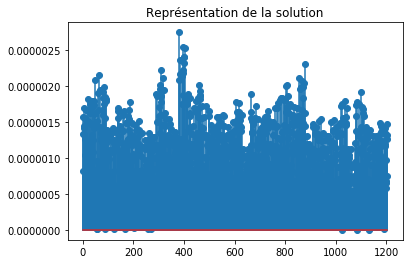

In [307]:
plt.stem(c_star)
titre = 'Représentation de la solution'
plt.title(titre)

KeyboardInterrupt: 

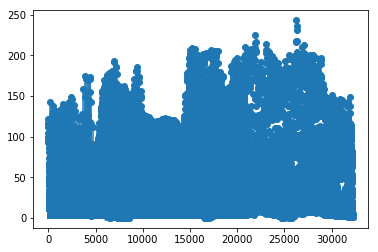

In [238]:
plt.stem(y)
titre = 'Représentation du signal'
plt.title(titre)

KeyboardInterrupt: 

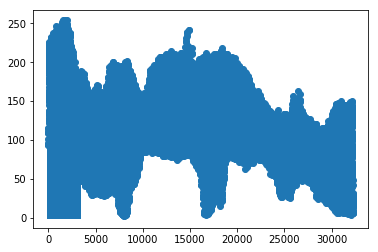

In [137]:
plt.stem(e_star)
titre = 'Représentation des erreurs'
plt.title(titre)

In [ ]:
y_rebuilt=A.dot(c)+e_star
plt.stem(y_rebuilt)
titre = 'Représentation de la reconstruction'
plt.title(titre)